# Demo for the DoWhy causal API
We show a simple example of adding a causal extension to any dataframe. 

In [1]:
import dowhy.datasets
import dowhy.api

import numpy as np
import pandas as pd

from statsmodels.api import OLS

In [2]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=1000,
        treatment_is_binary=True)
df = data['df']
df['y'] = df['y'] + np.random.normal(size=len(df)) # Adding noise to data. Without noise, the variance in Y|X, Z is zero, and mcmc fails.
#data['dot_graph'] = 'digraph { v ->y;X0-> v;X0-> y;}'

treatment= data["treatment_name"][0]
outcome = data["outcome_name"][0]
common_cause = data["common_causes_names"][0]
df

,W0,v0,y
0,0.196882,True,6.572437
1,0.572213,True,7.522597
2,0.915397,True,6.001227
3,-0.528673,False,-0.812860
4,0.358692,True,4.504694
...,...,...,...
995,-0.513807,False,0.801536
996,0.526521,True,6.140910
997,2.238583,True,9.246269
998,-0.488478,False,-1.706225


<AxesSubplot: xlabel='v0'>

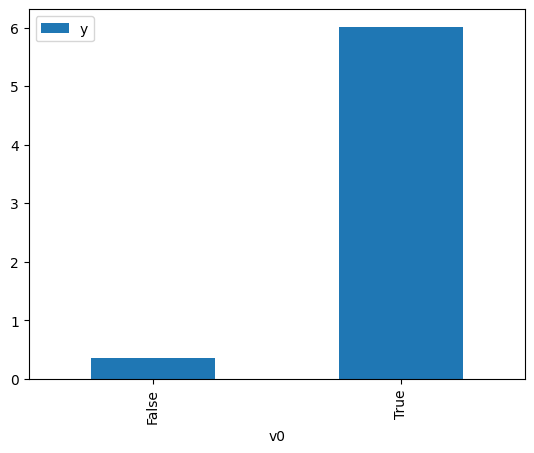

In [3]:
# data['df'] is just a regular pandas.DataFrame
df.causal.do(x=treatment,
                     variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'},
                     outcome=outcome,
                     common_causes=[common_cause],
                     proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

<AxesSubplot: xlabel='v0'>

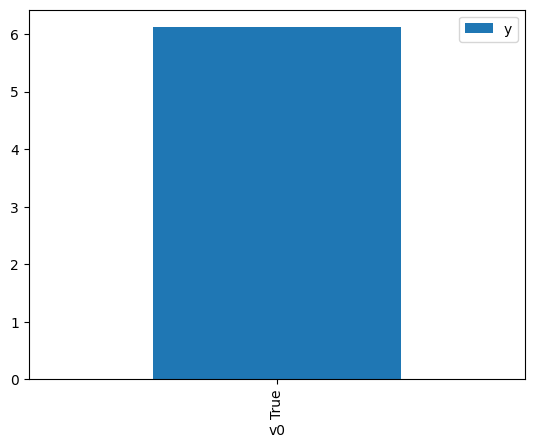

In [4]:
df.causal.do(x={treatment: 1}, 
              variable_types={treatment:'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome,
              method='weighting', 
              common_causes=[common_cause],
              proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

In [5]:
cdf_1 = df.causal.do(x={treatment: 1}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)

cdf_0 = df.causal.do(x={treatment: 0}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)


In [6]:
cdf_0

,W0,v0,y,propensity_score,weight
0,0.990746,False,2.590237,0.049776,20.090034
1,0.933770,False,0.226247,0.058265,17.163041
2,-0.844100,False,-2.666299,0.917645,1.089746
3,-0.306733,False,-0.287693,0.698680,1.431271
4,-0.806765,False,-2.809773,0.909019,1.100088
...,...,...,...,...,...
995,0.716922,False,0.407677,0.104399,9.578630
996,-0.024712,False,0.097778,0.504295,1.982965
997,1.100664,False,2.059952,0.036606,27.318108
998,0.233502,False,-1.113152,0.323637,3.089886


In [7]:
cdf_1

,W0,v0,y,propensity_score,weight
0,-0.205621,True,3.240250,0.366874,2.725731
1,0.700188,True,6.598756,0.890941,1.122409
2,0.004086,True,3.912412,0.516729,1.935250
3,-0.017804,True,5.492929,0.500750,1.997006
4,1.286763,True,8.445182,0.978414,1.022062
...,...,...,...,...,...
995,-0.535059,True,2.332497,0.181235,5.517696
996,0.043812,True,5.765371,0.545620,1.832777
997,2.436207,True,9.148052,0.999233,1.000768
998,1.294090,True,7.809679,0.978861,1.021595


## Comparing the estimate to Linear Regression
First, estimating the effect using the causal data frame, and the 95% confidence interval.

In [8]:
(cdf_1['y'] - cdf_0['y']).mean()

In [9]:
1.96*(cdf_1['y'] - cdf_0['y']).std() / np.sqrt(len(df))

Comparing to the estimate from OLS.

In [10]:
model = OLS(np.asarray(df[outcome]), np.asarray(df[[common_cause, treatment]], dtype=np.float64))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.966
Model:                            OLS   Adj. R-squared (uncentered):              0.966
Method:                 Least Squares   F-statistic:                          1.438e+04
Date:                Wed, 19 Oct 2022   Prob (F-statistic):                        0.00
Time:                        15:30:57   Log-Likelihood:                         -1442.0
No. Observations:                1000   AIC:                                      2888.
Df Residuals:                     998   BIC:                                      2898.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             1.6310      0.042     39.018      0.000       1.549       1.713
x2             4.9849      0.056     89.356      0.000       4.875       5.094
==============================================================================
Omnibus:                        0.651   Durbin-Watson:                   1.876
Prob(Omnibus):                  0.722   Jarque-Bera (JB):                0.737
Skew:                          -0.037   Prob(JB):                        0.692
Kurtosis:                       2.890   Cond. No.                         2.55
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""